<a href="https://colab.research.google.com/github/aashrat/stsci/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

In [21]:
transform = transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.4914, 0.4822, 0.4466), (0.247,            0.243, 0.261))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.4914, 0.4822, 0.4466), (0.247, 0.243, 0.261))])
trainset = tv.datasets.CIFAR10(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=36):
        return input.view(input.size(0), size, 1, 1)

In [31]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=2)
        self.conv2 = nn.Conv2d(32,128,kernel_size=3,padding=2)
        self.conv3 = nn.Conv2d(128,256,kernel_size=3,padding=2)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(2,return_indices=True)
        self.flatten = Flatten()

        size_before_latent = 256 * 32 * 32
        latent_dimensions = 2  
        self.latent = nn.Linear(size_before_latent, latent_dimensions)
        self.out_of_latent = nn.Linear(latent_dimensions, size_before_latent)

        self.unflatten = UnFlatten()
        self.up = nn.MaxUnpool2d(2)
        self.trans1 = nn.ConvTranspose2d(256,128,kernel_size=3,padding=2)
        self.trans2 = nn.ConvTranspose2d(128,32,kernel_size=3,padding=2)
        self.trans3 = nn.ConvTranspose2d(32,3,kernel_size=3,padding=2)

    def forward(self,x):
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x, ind = self.mp(x)
        x = self.flatten(x)

        # Reshape tensor into a linear set of neurons
        #   This is untested!
        #print(x.size())
        #x = x.view(-1, x.size()[1:])
        

        # Latent space
        x = self.latent(x)

        # Decoder
        # Reshape back into larger linear layer
        #   with the same size as before the latent
        x = self.out_of_latent(x)

        x = self.unflatten(x)
        # Start to upsample
        x = self.up(x, ind)
        x = self.relu(x)
        x = self.trans1(x)
        #x = self.up(x, ind1)
        x = self.relu(x)
        x = self.trans2(x)
        x = self.relu(x)
        x = self.trans3(x)
        x = self.relu(x)
        
        return x

In [32]:
testing = Autoencoder()
randomimage = np.random.normal(0,1,size=(1,3,128,128))
testoutput = testing(torch.Tensor(randomimage))
plt.imshow(testoutput.detach().numpy()[0,0])

RuntimeError: ignored

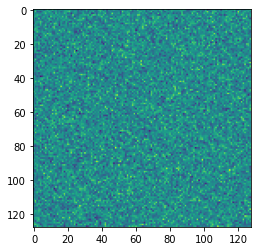

In [17]:
plt.imshow(randomimage[0,0])

In [14]:
#defining some params
num_epochs = 5
batch_size = 128

In [15]:
model = Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [16]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cpu()
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data()))

KeyboardInterrupt: ignored